In [54]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import time

In [68]:
def load_and_process_data(probability, total_time):
    start_time = time.time()
    # Get list of relevant files first
    files = [f for f in os.listdir('../simulation_results/prueba_25') 
             if f.startswith(f'realization_{probability}_') and f.endswith('_vel.csv')]

    # Pre-allocate list with known size
    dfs = [None] * len(files)

    for i, file in enumerate(files):
        # Extract realization ID from filename
        realization_id = file.split('_')[2]
        
        # Read the CSV
        temp_df = pd.read_csv(os.path.join('../simulation_results/prueba_25', file))
        # Add is_generated column with False for original values
        temp_df['is_generated'] = False
        
        # If simulation ended early, calculate all new rows at once
        if temp_df['Time'].max() < total_time:
            timestep = temp_df['Time'].iloc[1]
            last_row = temp_df.iloc[-1]
            
            # Calculate all new time points
            new_times = np.arange(temp_df['Time'].max() + timestep, total_time + timestep, timestep)
            
            # Create DataFrame of new rows efficiently
            new_rows = pd.DataFrame([last_row] * len(new_times))
            new_rows['Time'] = new_times
            # Mark generated rows
            new_rows['is_generated'] = True
            
            # Concatenate once
            temp_df = pd.concat([temp_df, new_rows], ignore_index=True)
        
        # Add realization ID column
        temp_df['realization'] = realization_id
        dfs[i] = temp_df

    # Combine all dataframes at once
    df = pd.concat(dfs, ignore_index=True)
    # Time, zombiePercentage, averageVelocity as float
    df['Time'] = df['Time'].astype(float)
    df['Time'] = df['Time'].round(2)
    df['zombiePercentage'] = df['zombiePercentage'].astype(float)
    df['averageVelocity'] = df['averageVelocity'].astype(float)

    # realization as int
    df['realization'] = df['realization'].astype(int)

    df = df[df['Time'] <= total_time]

    # print df columns types
    print('Probability: ', probability, '\nTime taken: ', round(time.time() - start_time, 2), 's')
    return df

In [56]:
fontsize = 14
linewidth = 2

def plot_zombie_percentage_over_time(df):
    # Graficar el porcentaje de zombis en función del tiempo para todas las realizaciones
    for realization in df['realization'].unique():
        realization_data = df[df['realization'] == realization]
        plt.plot(realization_data['Time'], realization_data['zombiePercentage'], 
                label=f'Realización {realization}')
    max_time = df['Time'].max()
    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.ylabel('Porcentaje de Zombies (%)', fontsize=fontsize)
    plt.ylim(0, 1)
    plt.xlim(0, max_time)
    plt.legend(fontsize=fontsize)
    plt.show()

    # Plot the mean zombiePercentage over time

def plot_mean_zombie_percentage_over_time(df):
    # Time repeated in the dataframe over realizations. Should be unique and the zombiePercentage should be the mean of all realizations at that time.
    grouped = df.groupby('Time')['zombiePercentage'].mean()
    sem = df.groupby('Time')['zombiePercentage'].sem()
    plt.plot(grouped.index, grouped.values, 'g-', linewidth=linewidth)
    max_time = df['Time'].max()
    # Add error bands
    plt.fill_between(grouped.index, grouped.values - sem, grouped.values + sem, alpha=0.3, color='g')

    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.ylabel('Porcentaje de Zombies (%)', fontsize=fontsize)
    plt.ylim(0, 1)
    plt.xlim(0, max_time)
    plt.show()

def plot_comparison_between_probabilities(dfs: list[pd.DataFrame], probabilities: list[float], selected_realizations: list[int]):
    # Plot the zombie percentage over time for the selected realizations from different probabilities. All index match for the three lists.
    for idx, probability, realization in zip(range(len(probabilities)), probabilities, selected_realizations):
        df = dfs[idx]
        realization_data = df[df['realization'] == realization]
        plt.plot(realization_data['Time'], realization_data['zombiePercentage'], 
                label=f'Probabilidad {probability}')
    max_time = df['Time'].max()
    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.ylabel('Porcentaje de Zombies (%)', fontsize=fontsize)
    plt.ylim(0, 1)
    plt.xlim(0, max_time)
    plt.legend(fontsize=fontsize)
    plt.show()

def plot_velocity_over_time(df):
    # Filter out generated rows
    df = df[~df['is_generated']]
    for realization in df['realization'].unique():
        realization_data = df[df['realization'] == realization]
        plt.plot(realization_data['Time'], realization_data['averageVelocity'], label=f'Realización {realization}')
    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.ylabel('Velocidad promedio (m/s)', fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.show()

def plot_velocity_over_time_mean(df):
    # Filter out generated rows
    df = df[~df['is_generated']]
    grouped = df.groupby('Time')['averageVelocity'].mean()
    sem = df.groupby('Time')['averageVelocity'].sem()
    plt.plot(grouped.index, grouped.values, 'g-', linewidth=linewidth)
    plt.fill_between(grouped.index, grouped.values - sem, grouped.values + sem, alpha=0.3, color='g')
    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.ylabel('Velocidad promedio (m/s)', fontsize=fontsize)
    plt.show()


In [57]:
total_time = 2000
df_05 = load_and_process_data('0.5', total_time)
df_06 = load_and_process_data('0.6', total_time)
df_065 = load_and_process_data('0.65', total_time)
df_07 = load_and_process_data('0.7', total_time)
df_075 = load_and_process_data('0.75', total_time)
df_08 = load_and_process_data('0.8', total_time)
df_10 = load_and_process_data('1.0', total_time)

Probability:  0.5 
Time taken:  7.53 s
Probability:  0.6 
Time taken:  6.37 s
Probability:  0.65 
Time taken:  6.81 s
Probability:  0.7 
Time taken:  6.62 s
Probability:  0.75 
Time taken:  6.44 s
Probability:  0.8 
Time taken:  6.7 s
Probability:  1.0 
Time taken:  6.93 s


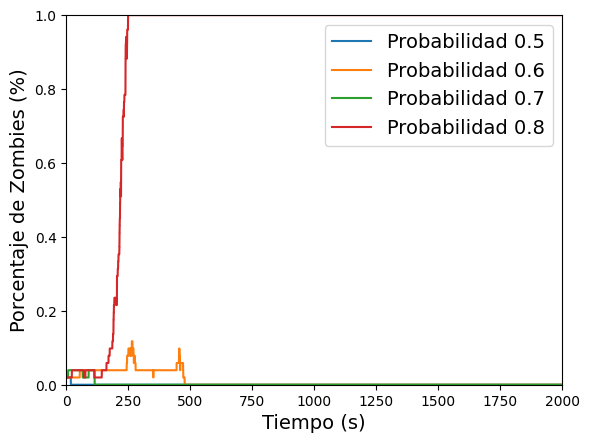

In [58]:
plot_comparison_between_probabilities([df_05, df_06, df_07, df_08], [0.5, 0.6, 0.7, 0.8], [3, 10, 7, 11])

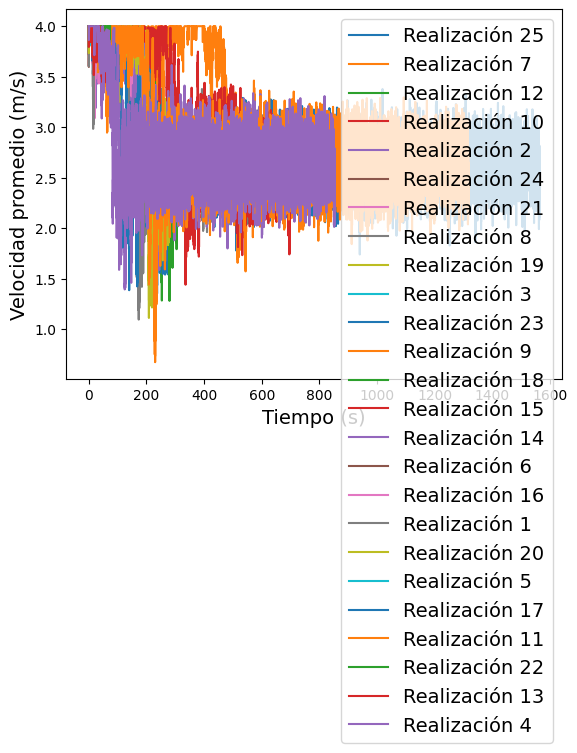

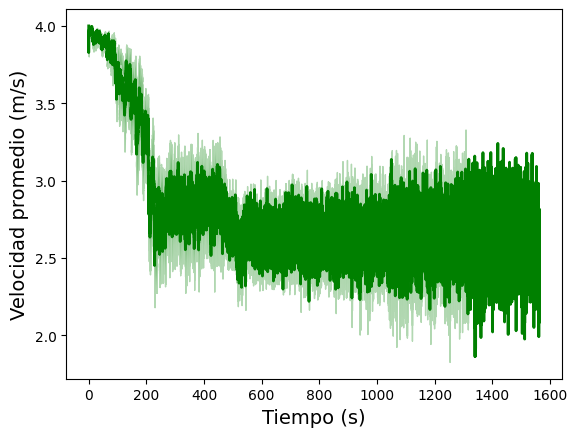

In [59]:
plot_velocity_over_time(df_07)
plot_velocity_over_time_mean(df_07)

Probability:  0.5 
Time taken:  21.3 s


/home/adolfo/IdeaProjects/SdS_Final_2024Q2G08/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


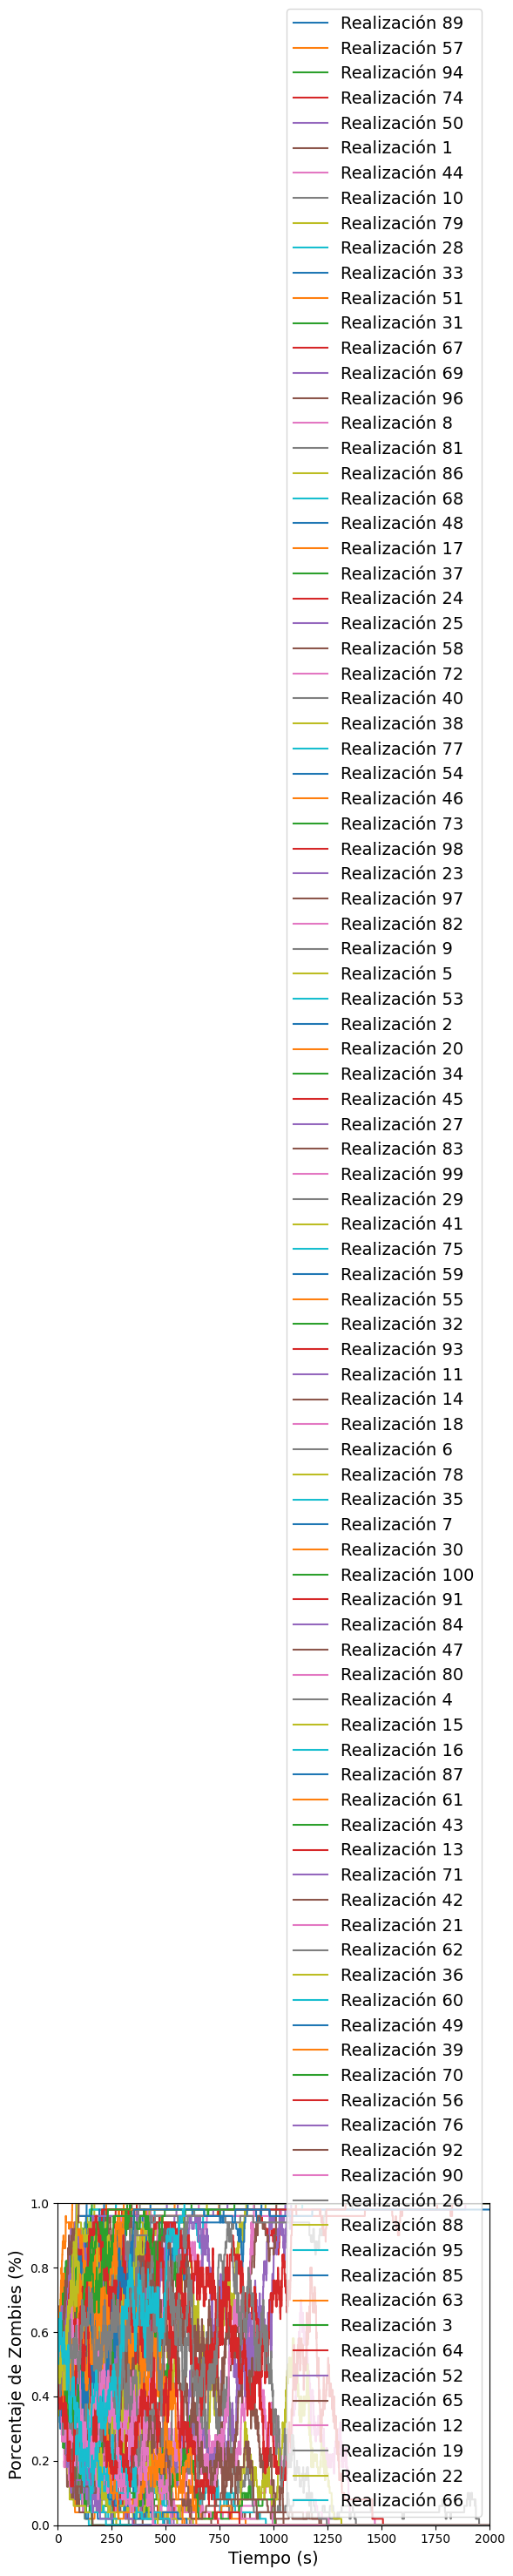

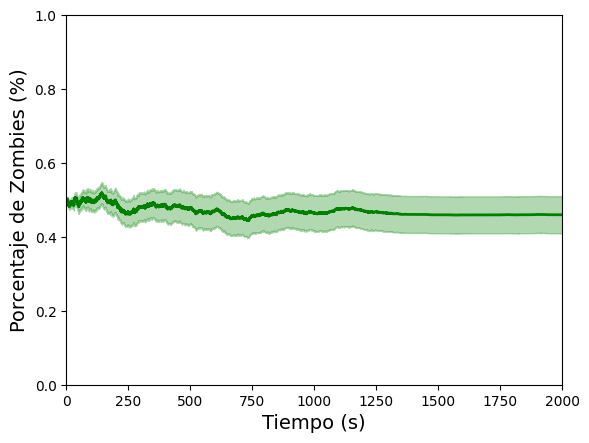

In [70]:
total_time = 2000
df_05 = load_and_process_data('0.5', total_time)
plot_zombie_percentage_over_time(df_05)
plot_mean_zombie_percentage_over_time(df_05)

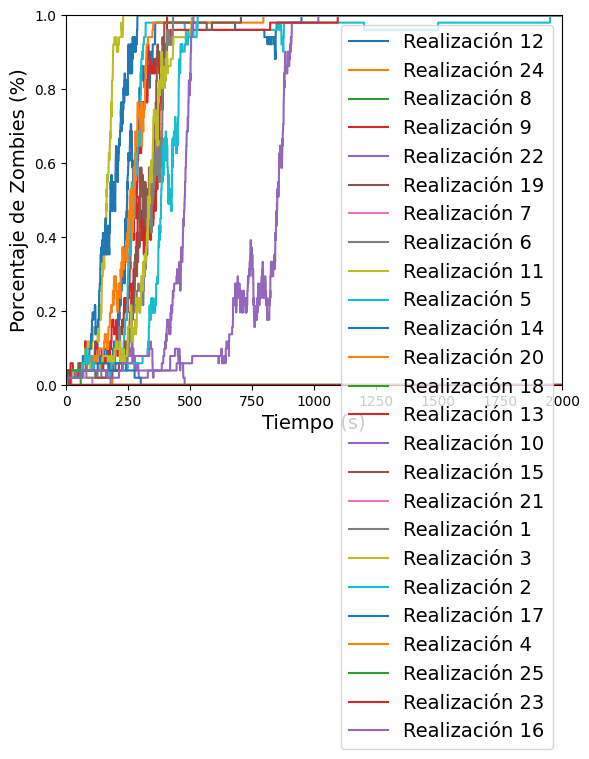

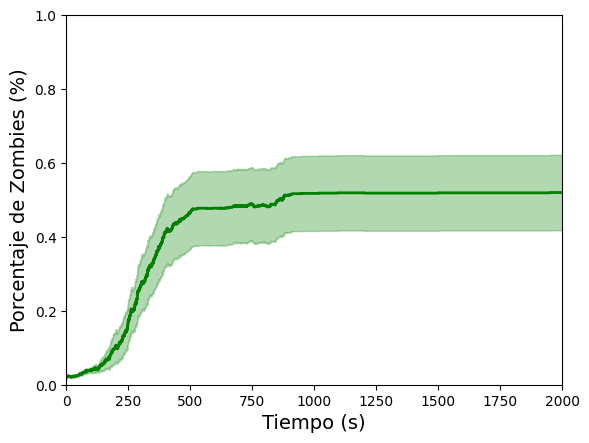

In [61]:
plot_zombie_percentage_over_time(df_06)
plot_mean_zombie_percentage_over_time(df_06)

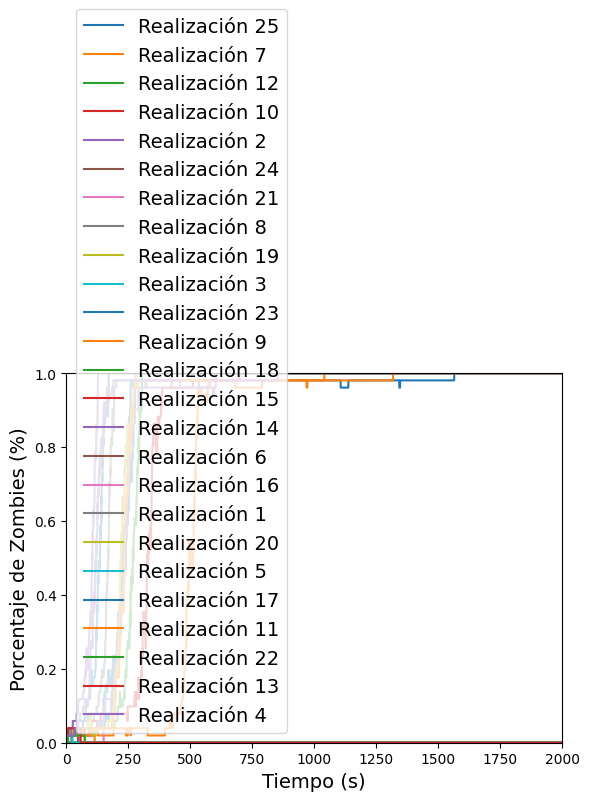

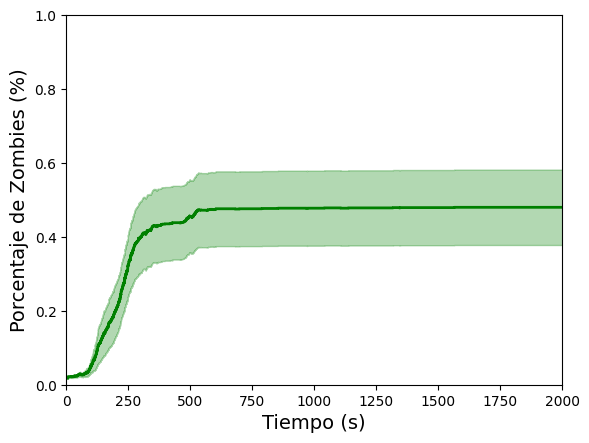

In [62]:
plot_zombie_percentage_over_time(df_07)
plot_mean_zombie_percentage_over_time(df_07)

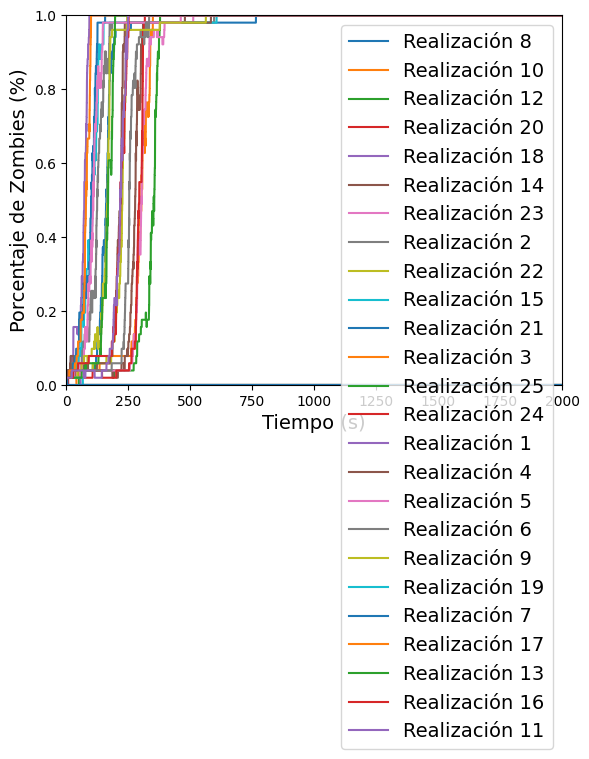

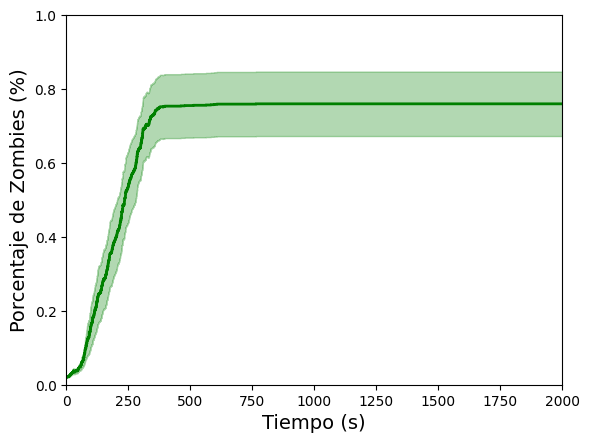

In [63]:
plot_zombie_percentage_over_time(df_08)
plot_mean_zombie_percentage_over_time(df_08)